### Libs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

/home/diogo/Documents/projetos-teste/time_series_studies/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Importing the data

In [2]:
df = pd.read_csv('solar-cargas-dia-fortal.csv', 
                index_col=[0],
                parse_dates=[0])
df.head()

,total_loads
start_of_operation,
2023-01-02,95
2023-01-03,92
2023-01-04,92
2023-01-05,100
2023-01-06,92


### Gereral data - Vizualization

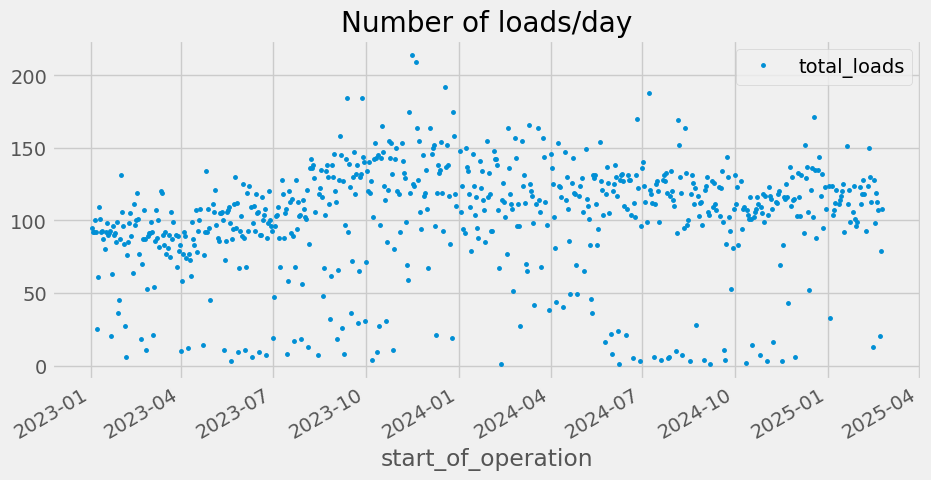

In [3]:
palette_color = sns.color_palette()
df.plot(style='.',
       figsize=(10,5),
       ms=5,
       color=palette_color[0],
       title='Number of loads/day')
plt.show()

### Time Series Features

In [4]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday',
                                       'Wednesday', 
                                       'Thursday', 'Friday',
                                       'Saturday', 'Sunday'], 
                           ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    # df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    # df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    # df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
    #                       labels=['Spring', 'Summer', 'Fall', 'Winter']
                   # )
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='total_loads')
features_and_target = pd.concat([X, y], axis=1)

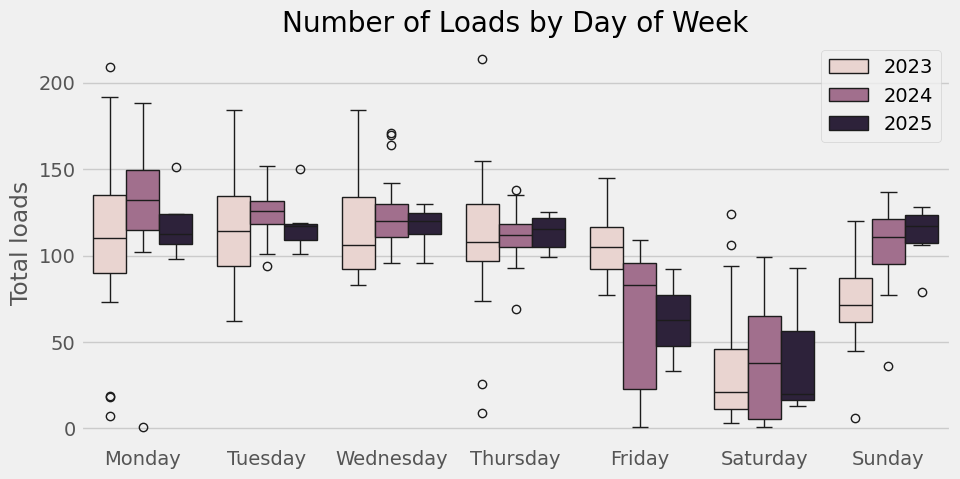

In [5]:
# grouped by week
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='total_loads',
            hue='year',
            ax=ax,
            linewidth=1)
ax.set_title('Number of Loads by Day of Week')
ax.set_xlabel('')
ax.set_ylabel('Total loads')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

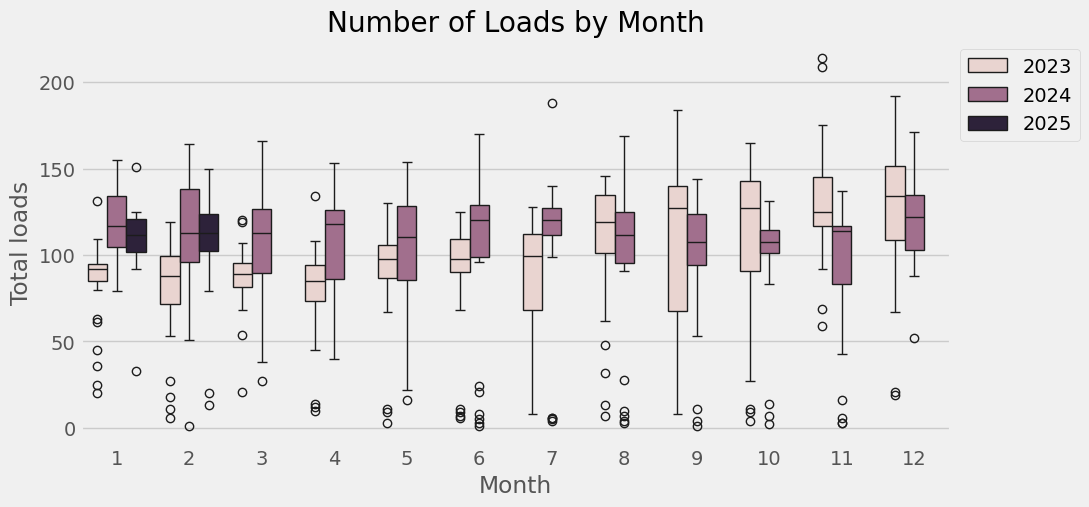

In [6]:
# grouped by month
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='month',
            y='total_loads',
            hue='year',
            ax=ax,
            linewidth=1)
ax.set_title('Number of Loads by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Total loads')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [7]:
features_and_target.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,total_loads
start_of_operation,,,,,,,,,
2023-01-02,0,1,1,2023,2,2,1,Monday,95
2023-01-03,1,1,1,2023,3,3,1,Tuesday,92
2023-01-04,2,1,1,2023,4,4,1,Wednesday,92
2023-01-05,3,1,1,2023,5,5,1,Thursday,100
2023-01-06,4,1,1,2023,6,6,1,Friday,92


### Grouping data by week and month

In [34]:
df_month = features_and_target.groupby(['year','month'], as_index=False)['total_loads'].sum()
df_month.head()

,year,month,total_loads
0,2023,1,2426
1,2023,2,2054
2,2023,3,2348
3,2023,4,2035
4,2023,5,2608


In [18]:
df_month.shape

(26, 3)

In [39]:
df_month['month_year'] = df_month['month'].astype(str)+'-'+df_month['year'].astype(str)
df_month['month_year'] = pd.to_datetime(df_month['month_year'])
df_month.head()

,year,month,total_loads,month_year
0,2023,1,2426,2023-01-01
1,2023,2,2054,2023-02-01
2,2023,3,2348,2023-03-01
3,2023,4,2035,2023-04-01
4,2023,5,2608,2023-05-01


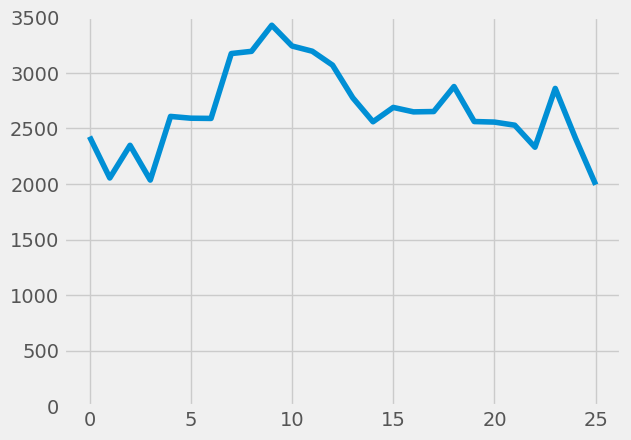

In [36]:
df_month['total_loads'].plot()
plt.ylim(0,3500)
plt.show()

In [13]:
df_week = features_and_target.groupby(['year','weekofyear'], as_index=False)['total_loads'].sum()
df_week.head()

,year,weekofyear,total_loads
0,2023,1,557
1,2023,2,562
2,2023,3,547
3,2023,4,542
4,2023,5,537


In [14]:
df_week.shape

(113, 3)

In [15]:
df_week.dtypes

year            int32
weekofyear     UInt32
total_loads     int64
dtype: object

<Axes: >

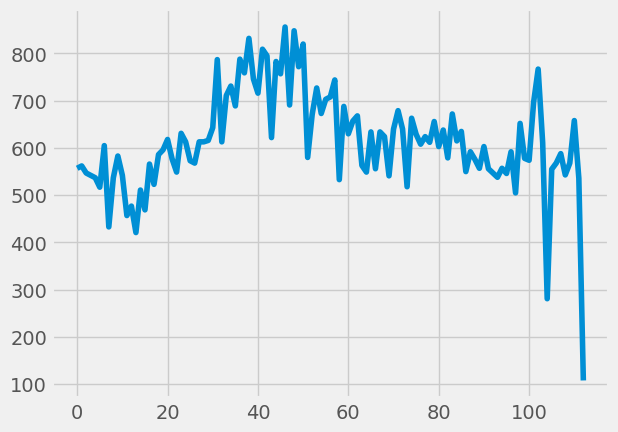

In [32]:
df_week['total_loads'].plot()

### Training data

In [52]:
df_train = df_month.loc[df_month['month_year']<'12-2024', ['month_year','total_loads']]
df_train.head()

,month_year,total_loads
0,2023-01-01,2426
1,2023-02-01,2054
2,2023-03-01,2348
3,2023-04-01,2035
4,2023-05-01,2608


In [61]:
df_test = df_month.loc[(df_month['month_year']=='12-2024')(df_month['month_year']=='01-2025'), ['month_year','total_loads']]
df_test

,month_year,total_loads


### Decomposing the training data

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df_data_train.Passengers, model='additive', extrapolate_trend='freq', period=12)

decompose.plot().show()